In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing libaries and dataset


 This project aims to employ advanced clustering techniques, specifically K-means algorithm, along with Relative Strength Index (RSI) and Average True Range (ATR), to group Nifty 50 stocks based on their trading patterns.

By leveraging historical stock data, we apply the K-means clustering algorithm to categorize stocks into distinct groups. RSI, a momentum oscillator, and ATR, a volatility indicator, are incorporated to capture different aspects of stock behavior. The combination of these metrics allows for a more comprehensive clustering approach, aiding investors in making informed decisions.

In [ ]:
!pip install pandas_ta

In [ ]:
!pip install PyPortfolioOpt

In [61]:
# Import necessary libraries and modules
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Import modules from PyPortfolioOpt library
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


In [62]:
nifty50 = pd.read_csv("/content/drive/MyDrive/capstone/nifty50list.csv")

In [97]:
# Extract unique symbols
symbols_list = nifty50['Symbol'].unique().tolist()

# end date for data retrieval
end_date = '2023-02-14'

# Finding our start date by subtracting 8 years from the end date
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Download historical using the 'yf.download()' function to Stack the DataFrame to create a MultiIndex DataFrame with 'date' and 'ticker' as index levels
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()
df


[*********************100%%**********************]  50 of 50 completed


Price                       adj close        close         high          low  \
date       ticker                                                              
2015-02-16 ADANIENT.NS      95.650948   101.621361   105.008743   100.778351   
           ADANIPORTS.NS   315.692596   331.250000   341.700012   329.649994   
           APOLLOHOSP.NS  1255.826904  1298.650024  1321.250000  1276.800049   
           ASIANPAINT.NS   783.533142   834.150024   842.500000   818.000000   
           AXISBANK.NS     552.960510   570.299988   584.000000   566.099976   
...                               ...          ...          ...          ...   
2023-02-13 TECHM.NS        941.629883  1002.500000  1017.799988  1000.500000   
           TITAN.NS       2510.915039  2519.050049  2523.949951  2476.149902   
           ULTRACEMCO.NS  7146.586914  7179.250000  7250.000000  7155.000000   
           UPL.NS          721.948242   733.799988   736.400024   725.000000   
           WIPRO.NS        399.747467   400.600006   405.649994   399.200012   

Price                            open      volume  
date       ticker                                  
2015-02-16 ADANIENT.NS     103.338043  11523388.0  
           ADANIPORTS.NS   335.100006   2205960.0  
           APOLLOHOSP.NS  1305.000000    174397.0  
           ASIANPAINT.NS   834.000000   1584956.0  
           AXISBANK.NS     583.000000   4284303.0  
...                               ...         ...  
2023-02-13 TECHM.NS       1015.000000   1682312.0  
           TITAN.NS       2480.000000   1856317.0  
           ULTRACEMCO.NS  7215.000000    323236.0  
           UPL.NS          730.000000   1265376.0  
           WIPRO.NS        405.649994   2412678.0  

[97073 rows x 6 columns]

## EDA

In [98]:
# Display summary statistics for each level of the index
print(df.describe())


Price     adj close         close          high           low          open  \
count  97073.000000  97073.000000  97073.000000  97073.000000  97073.000000   
mean    1206.149750   1273.955769   1290.693536   1258.129790   1275.210853   
std     1424.973915   1473.768856   1492.179926   1456.831605   1475.599455   
min       15.463523     19.188114     19.693066     19.026150     19.531101   
25%      306.057800    334.299988    339.649994    329.319397    334.546692   
50%      677.809998    710.150024    719.549988    701.700012    710.950012   
75%     1562.437744   1633.699951   1655.000000   1611.641724   1634.199951   
max     9438.776367   9832.450195   9996.400391   9725.000000   9966.000000   

Price        volume  
count  9.707300e+04  
mean   7.819218e+06  
std    1.940367e+07  
min    0.000000e+00  
25%    9.587170e+05  
50%    2.763385e+06  
75%    7.225481e+06  
max    6.428460e+08  


In [99]:
# Display basic information about the DataFrame
print(df.info())


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 97073 entries, (Timestamp('2015-02-16 00:00:00'), 'ADANIENT.NS') to (Timestamp('2023-02-13 00:00:00'), 'WIPRO.NS')
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   adj close  97073 non-null  float64
 1   close      97073 non-null  float64
 2   high       97073 non-null  float64
 3   low        97073 non-null  float64
 4   open       97073 non-null  float64
 5   volume     97073 non-null  float64
dtypes: float64(6)
memory usage: 4.8+ MB
None


Data Overview:

- The dataset consists of 97,761 entries with a MultiIndex where the levels are 'Timestamp' and 'Ticker'.
- There are 6 columns representing various price-related attributes: 'Adj Close', 'Close', 'High', 'Low', 'Open', and 'Volume'.

Data Summary:

- The 'Adj Close', 'Close', 'High', 'Low', and 'Open' columns have no missing values (non-null count equals the total count).
- The 'Volume' column also has no missing values.

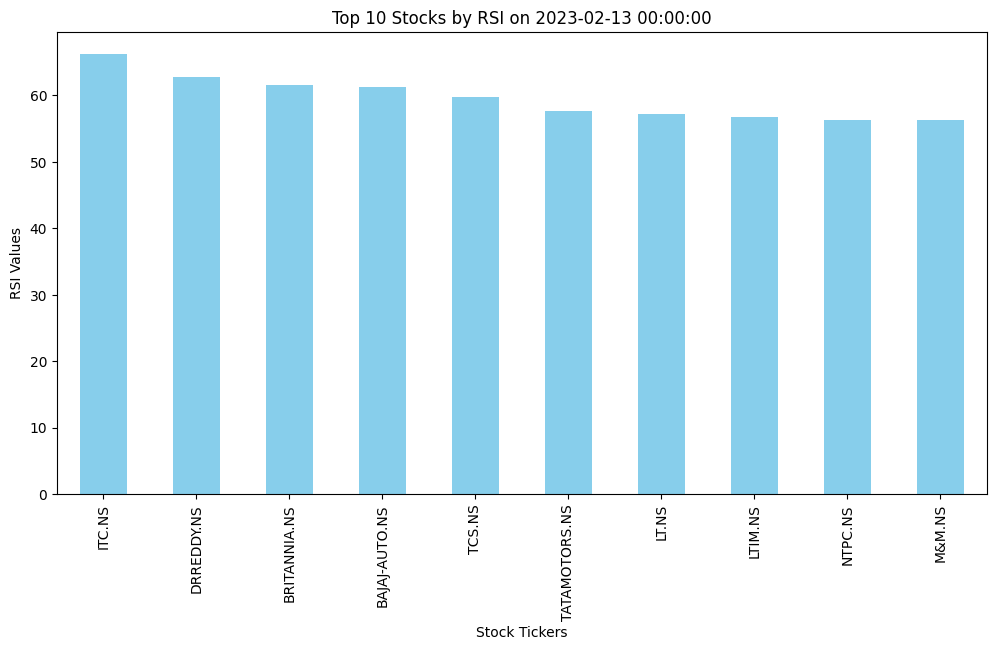

In [106]:

date_of_interest = pd.to_datetime('2023-02-13')

# Extract RSI values for the top 10 stocks on the specified date

top_10_rsi = df.loc[date_of_interest].nlargest(10, 'rsi')['rsi']

# Plot the RSI values
plt.figure(figsize=(12, 6))
top_10_rsi.plot(kind='bar', color='skyblue')
plt.title(f'Top 10 Stocks by RSI on {date_of_interest}')
plt.xlabel('Stock Tickers')
plt.ylabel('RSI Values')
plt.show()


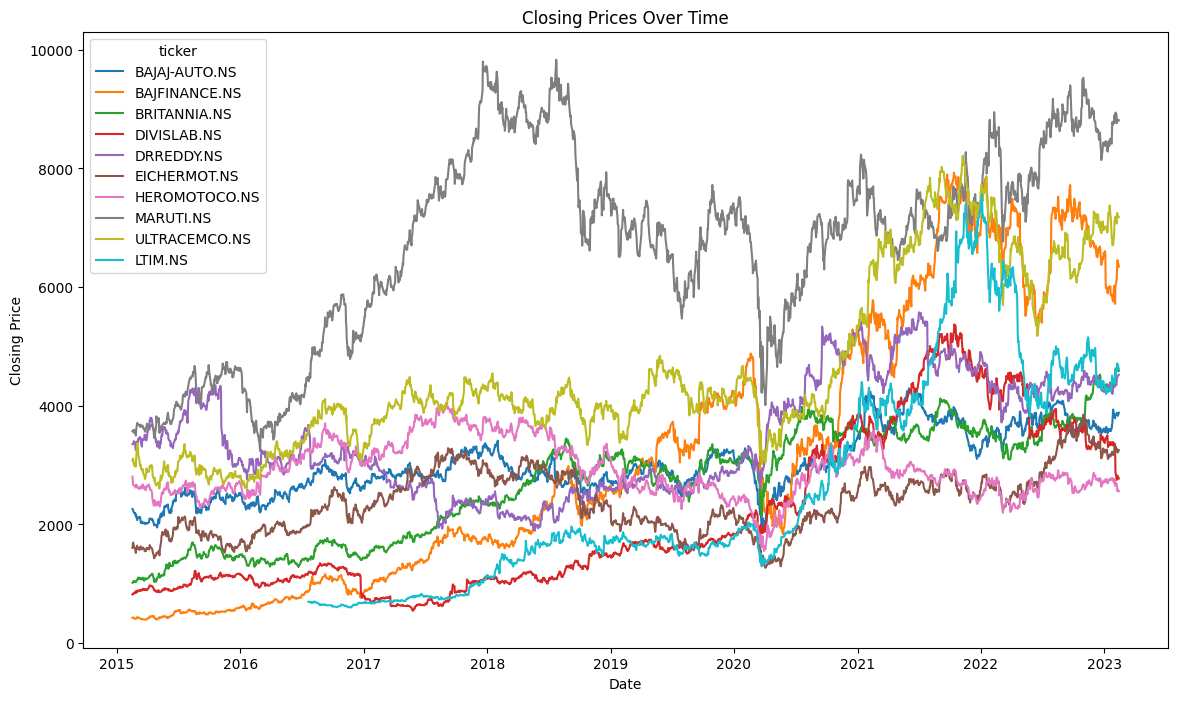

In [107]:
# Sort symbols based on some criterion (e.g., average closing price over the period)
top_symbols = df.groupby('ticker')['close'].mean().sort_values(ascending=False).head(10).index.tolist()

# Plot the closing prices over time for a subset of symbols
df_subset = df.loc[df.index.get_level_values('ticker').isin(top_symbols), 'close']

plt.figure(figsize=(14, 8))
sns.lineplot(x='date', y='close', hue='ticker', data=df_subset.reset_index())
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


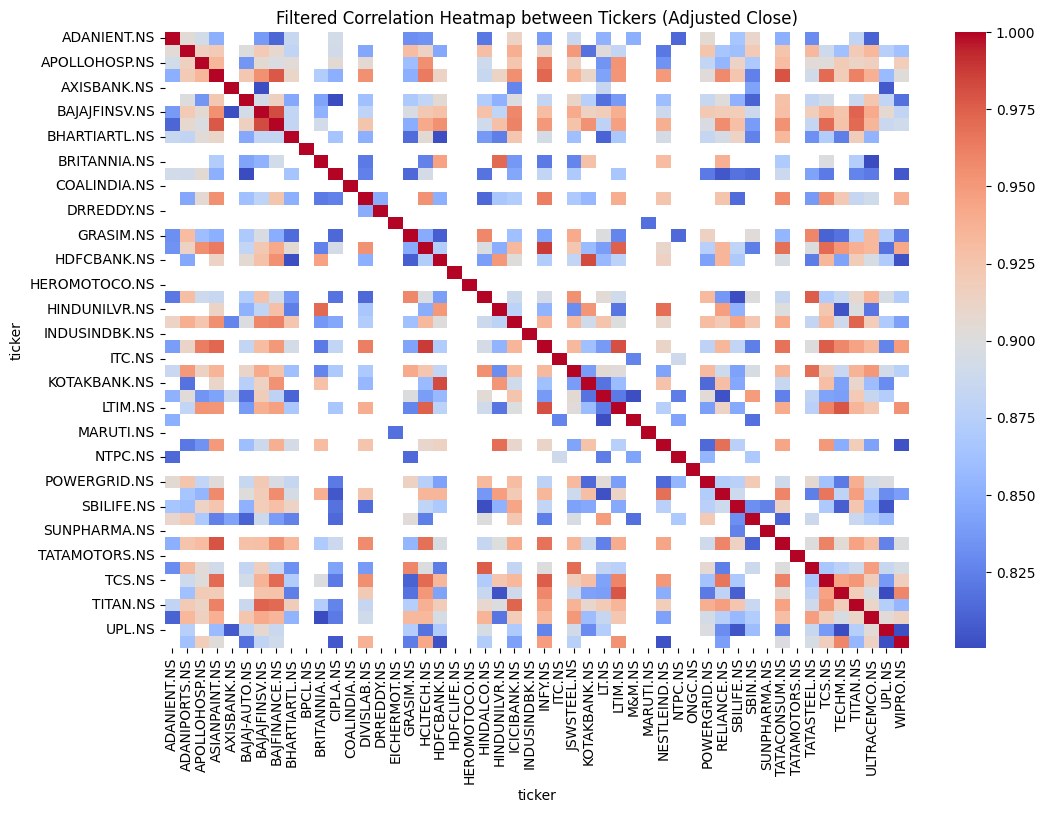

In [108]:
correlation_threshold = 0.8

# Select only the 'adj close' column
adj_close_data = df['adj close']

# Unstack the DataFrame to pivot tickers into columns
unstacked_data = adj_close_data.unstack(level='ticker')

# Calculate the correlation matrix
correlation_matrix = unstacked_data.corr()

# Filter the correlation matrix
highly_correlated = correlation_matrix[(correlation_matrix > correlation_threshold) | (correlation_matrix < -correlation_threshold)]

# Plot the filtered heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(highly_correlated, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Filtered Correlation Heatmap between Tickers (Adjusted Close)')
plt.show()

## Feature engineering and selection





RSI offer insights into trend strength and potential reversals.


ATR provide measures of volatility for risk assessment.


- Relative Strength Index (RSI):

Purpose: Measures the speed and magnitude of price changes, indicating overbought or oversold conditions.

Reason for Choosing:
Helps identify potential reversals in price trends.
Provides insights into the strength of a stock's recent price movements.
Useful for assessing whether a stock is overvalued or undervalued.
RSI values above 70 indicate potential overbought conditions, suggesting the stock may be due for a correction.
RSI values below 30 suggest potential oversold conditions, indicating the stock may be undervalued.
RSI values can indicate the strength of a trend. Rising RSI values suggest increasing strength in an uptrend, while falling RSI values suggest increasing strength in a downtrend


- Average True Range (ATR):

Purpose: Measures market volatility by considering price ranges.

Reason for Choosing:
Reflects the average trading range of a stock, considering price gaps and limit moves.
Helps in setting appropriate stop-loss levels and understanding potential breakouts.
Normalization by mean and standard deviation provides a standardized measure for comparison.

In [102]:
# Relative Strength Index (RSI) Calculation
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))


# Average True Range (ATR) Calculation
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)




### Relative Strength Index (RSI):

The RSI is a momentum oscillator that measures the speed and change of price movements. It oscillates between 0 and 100 and is typically used to identify overbought or oversold conditions in a market.

The formula for RSI is:
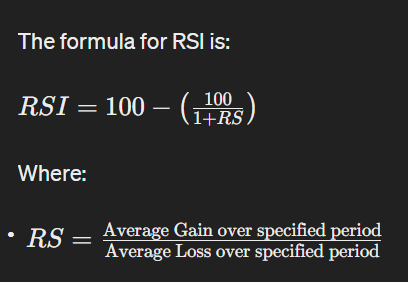

Typically, the RSI is calculated over a 14-day period. A high RSI value (above 70) is often interpreted as overbought, suggesting that the asset may be overvalued and a reversal could be imminent. Conversely, a low RSI value (below 30) is considered oversold, indicating that the asset may be undervalued and a reversal to the upside could occur.



### Average True Range (ATR):

The ATR is a measure of market volatility and helps traders understand the average range (price movement) of an asset over a given period.

The formula for ATR is:
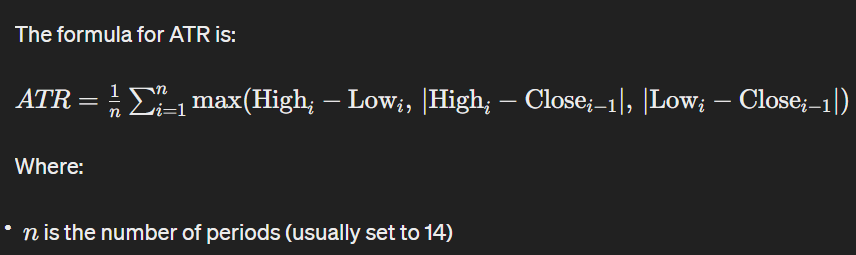
The ATR is expressed in the same units as the asset's price. A higher ATR indicates higher volatility, while a lower ATR suggests lower volatility.



### Significance in Stock Clustering and Analysis:

1. **RSI in Clustering:** RSI can be used to identify stocks with similar momentum characteristics. Clustering stocks based on RSI values may reveal groups of stocks exhibiting similar overbought or oversold conditions.

2. **ATR in Clustering:** ATR, representing volatility, can be useful in grouping stocks with similar levels of price fluctuation. Clustering stocks based on ATR values may identify groups with different risk profiles.

3. **Combined Analysis:** Incorporating RSI and ATR, along with other technical indicators, can provide a more comprehensive view for stock clustering. For example, clustering stocks based on a combination of momentum (RSI) and volatility (ATR) could offer insights into different trading or investment strategies.


## Aggregating to monthly
We will aggregate to monthly level for ease of training our data.
We use iteration method so we dont lose the multi index nature of our data

In [109]:
# Create a new DataFrame 'data' by resampling and selecting specific columns

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'garman_klass_vol', 'bb_high',	'bb_low',	'bb_mid',	'macd']]

data = df.unstack()[last_cols].resample('M').last().stack('ticker').dropna()
                  # axis=1))

data

Price                       adj close        close         high          low  \
date       ticker                                                              
2015-03-31 ADANIENT.NS      88.776489    94.317810    97.023109    93.750687   
           ADANIPORTS.NS   293.725189   308.200012   315.450012   305.049988   
           APOLLOHOSP.NS  1324.050659  1369.199951  1379.849976  1333.000000   
           ASIANPAINT.NS   762.069824   811.299988   817.000000   802.049988   
           AXISBANK.NS     543.167542   560.200012   573.500000   557.250000   
...                               ...          ...          ...          ...   
2023-02-28 TECHM.NS        941.629883  1002.500000  1017.799988  1000.500000   
           TITAN.NS       2510.915039  2519.050049  2523.949951  2476.149902   
           ULTRACEMCO.NS  7146.586914  7179.250000  7250.000000  7155.000000   
           UPL.NS          721.948242   733.799988   736.400024   725.000000   
           WIPRO.NS        399.747467   400.600006   405.649994   399.200012   

Price                            open     volume        rsi       atr  
date       ticker                                                      
2015-03-31 ADANIENT.NS      95.352417  8187770.0  41.295985 -0.555835  
           ADANIPORTS.NS   311.000000  2590770.0  42.797651 -0.478600  
           APOLLOHOSP.NS  1338.000000   188491.0  51.256381 -0.267214  
           ASIANPAINT.NS   807.900024   947718.0  48.170010 -0.917398  
           AXISBANK.NS     567.900024  5970862.0  46.393071  0.398721  
...                               ...        ...        ...       ...  
2023-02-28 TECHM.NS       1015.000000  1682312.0  44.040356 -0.063023  
           TITAN.NS       2480.000000  1856317.0  55.701482  1.173242  
           ULTRACEMCO.NS  7215.000000   323236.0  54.002156  0.812310  
           UPL.NS          730.000000  1265376.0  50.577420  0.206852  
           WIPRO.NS        405.649994  2412678.0  50.891494 -0.154437  

[4718 rows x 8 columns]

In [110]:
# This code calculates the minimum and maximum values of the ATR column and then standardizes the ATR values to have them between 0 and 1

from sklearn.preprocessing import StandardScaler

# Check the range of ATR values
min_atr = data['atr'].min()
max_atr = data['atr'].max()

# Standardize ATR values between 0 and 1
data['atr'] = (data['atr'] - min_atr) / (max_atr - min_atr)
data


Price                       adj close        close         high          low  \
date       ticker                                                              
2015-03-31 ADANIENT.NS      88.776489    94.317810    97.023109    93.750687   
           ADANIPORTS.NS   293.725189   308.200012   315.450012   305.049988   
           APOLLOHOSP.NS  1324.050659  1369.199951  1379.849976  1333.000000   
           ASIANPAINT.NS   762.069824   811.299988   817.000000   802.049988   
           AXISBANK.NS     543.167542   560.200012   573.500000   557.250000   
...                               ...          ...          ...          ...   
2023-02-28 TECHM.NS        941.629883  1002.500000  1017.799988  1000.500000   
           TITAN.NS       2510.915039  2519.050049  2523.949951  2476.149902   
           ULTRACEMCO.NS  7146.586914  7179.250000  7250.000000  7155.000000   
           UPL.NS          721.948242   733.799988   736.400024   725.000000   
           WIPRO.NS        399.747467   400.600006   405.649994   399.200012   

Price                            open     volume        rsi       atr  
date       ticker                                                      
2015-03-31 ADANIENT.NS      95.352417  8187770.0  41.295985  0.159714  
           ADANIPORTS.NS   311.000000  2590770.0  42.797651  0.167525  
           APOLLOHOSP.NS  1338.000000   188491.0  51.256381  0.188904  
           ASIANPAINT.NS   807.900024   947718.0  48.170010  0.123147  
           AXISBANK.NS     567.900024  5970862.0  46.393071  0.256254  
...                               ...        ...        ...       ...  
2023-02-28 TECHM.NS       1015.000000  1682312.0  44.040356  0.209555  
           TITAN.NS       2480.000000  1856317.0  55.701482  0.334586  
           ULTRACEMCO.NS  7215.000000   323236.0  54.002156  0.298083  
           UPL.NS          730.000000  1265376.0  50.577420  0.236849  
           WIPRO.NS        405.649994  2412678.0  50.891494  0.200310  

[4718 rows x 8 columns]

## Hierarchical Clustering

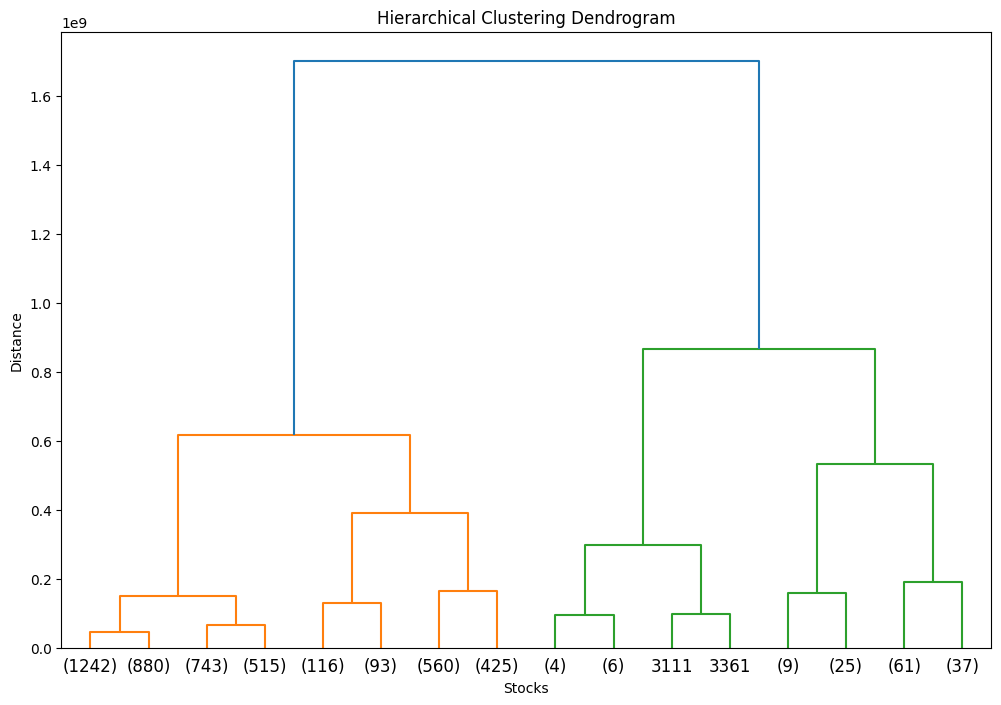

In [111]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Define a function to create a dendrogram and identify the optimal number of clusters
def plot_dendrogram(data, method='ward'):
    # Exclude non-numeric columns and drop rows with missing values
    X = data

    # Perform hierarchical clustering
    linkage_matrix = linkage(X, method=method)

    # Plot the dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, truncate_mode='level', p=3)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Stocks')
    plt.ylabel('Distance')

    # Use plt.show() if running the code outside of a Jupyter environment
    plt.show()

# Call the plot_dendrogram function with your data
plot_dendrogram(data)


Description: It minimizes the variance within each cluster. Ward's method is based on the analysis of variance (ANOVA).
Pros: Tends to produce compact, spherical clusters; minimizes variance.
Cons: Sensitive to outliers; computationally more intensive.

## Kmeans Clustering

Using elbow method:

The elbow method is a common technique used to determine the optimal number of clusters in a K-Means clustering algorithm. The elbow of the plot indicates a point where adding more clusters doesn't significantly improve the explained variance. The number of clusters corresponding to the elbow is a good candidate for the optimal number of clusters.

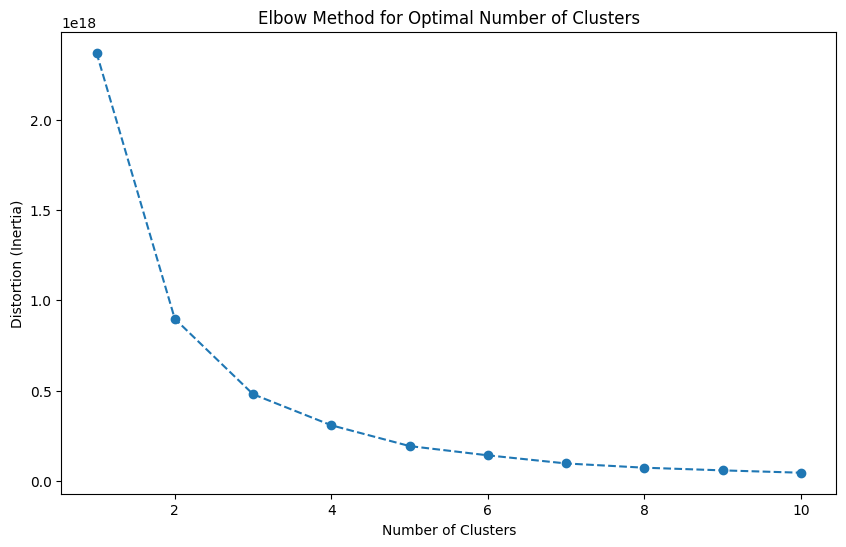

In [112]:
from sklearn.cluster import KMeans
# Elbow method to find the optimal number of clusters
def find_optimal_clusters(data, max_clusters=10):
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.show()

# Call the function with your data
find_optimal_clusters(data, max_clusters=10)

Silhouette Score method

Understanding Silhouette Score:
A higher silhouette score indicates better-defined clusters.
The optimal number of clusters (K) is often associated with a peak or plateau in the silhouette score.
Why Silhouette Method:

Silhouette score is a useful metric to evaluate the quality of clustering, especially when the ground truth (true cluster labels) is unknown.
It provides a quantitative measure of how well-separated the clusters are.
The goal is to choose a K value that maximizes the silhouette score.

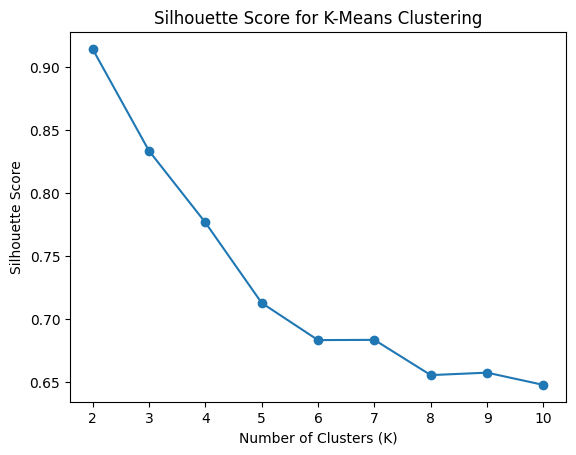

In [113]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = data

# Define a range of K values to try
k_values = range(2, 11)

# Perform K-Means clustering for each K and calculate silhouette score
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the silhouette scores for different K values
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering')
plt.show()


Changing from Random to RSI and ATR based clustering -

We would like to follow stocks momentum, and we are using RSI as the main indicator. Stocks which are around 70 RSI are in an upward momentum. in out strategy we would like to invest in the stocks that had the highest momentum throughout the previous month. For the purpose we are focusing on stocks clustered around 65-75 RSI, Therefore using the random initisalisation of the clusters wont work, so we help the clustering algorithm by supplying initial centroids

Applying pre- defined centroid

In [114]:
# Define target values for RSI and ATR
target_rsi_values = [30, 45, 55, 70]
target_atr_value = 0.2

# Create an array for centroids with zeros
initial_centroids = np.zeros((len(target_rsi_values), 2))

# Set RSI values in the centroids array
initial_centroids[:, 0] = target_rsi_values

# Set ATR value in the centroids array
initial_centroids[:, 1] = target_atr_value

# Create a DataFrame for centroids
centroids_df = pd.DataFrame(initial_centroids, columns=['rsi', 'atr'])

# Display the centroids DataFrame
print(centroids_df)

    rsi  atr
0  30.0  0.2
1  45.0  0.2
2  55.0  0.2
3  70.0  0.2


In [147]:
# Perform KMeans clustering with the specified centroids
data = data[['rsi', 'atr']].dropna()
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init=centroids_df, random_state=0)

# Fit the model to the data and get cluster labels
data['cluster'] = kmeans.fit_predict(data)
# Display the resulting DataFrame with cluster labels
print(data)


                                rsi       atr  cluster
date       ticker                                     
2023-03-31 ADANIENT.NS    50.106952  1.362586        1
           ADANIPORTS.NS  51.309748  0.914347        1
           APOLLOHOSP.NS  42.303799 -0.785629        0
           ASIANPAINT.NS  43.687364  0.001869        0
           AXISBANK.NS    53.365977 -0.438377        1
...                             ...       ...      ...
2024-02-29 TECHM.NS       49.043714  1.744143        1
           TITAN.NS       46.620980  2.764402        1
           ULTRACEMCO.NS  48.331467  2.521590        1
           UPL.NS         34.773045  1.849931        0
           WIPRO.NS       66.916468  2.647761        3

[600 rows x 3 columns]


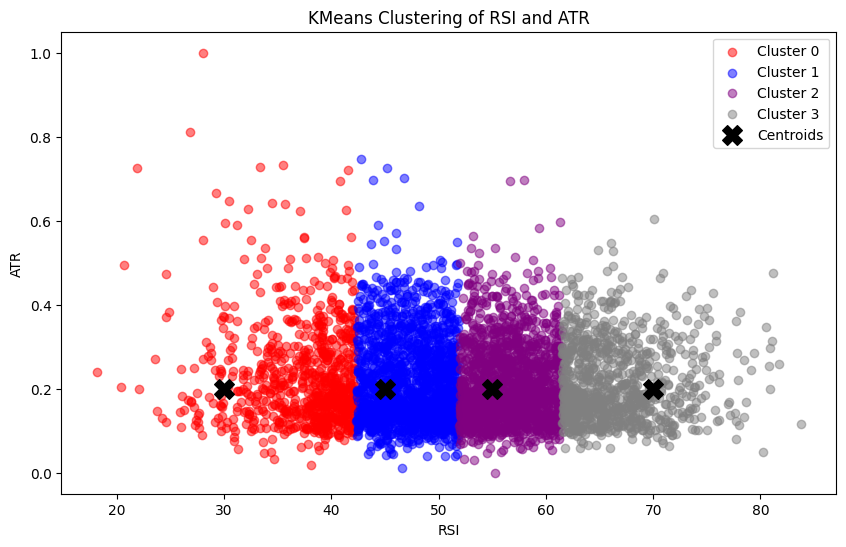

In [116]:
# Separate data points based on their assigned clusters
cluster0 = data[data['cluster'] == 0]
cluster1 = data[data['cluster'] == 1]
cluster2 = data[data['cluster'] == 2]
cluster3 = data[data['cluster'] == 3]

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(cluster0['rsi'], cluster0['atr'], label='Cluster 0', alpha=0.5, color='red')
plt.scatter(cluster1['rsi'], cluster1['atr'], label='Cluster 1', alpha=0.5, color='blue')
plt.scatter(cluster2['rsi'], cluster2['atr'], label='Cluster 2', alpha=0.5, color='purple')
plt.scatter(cluster3['rsi'], cluster3['atr'], label='Cluster 3', alpha=0.5, color='grey')

# Plot centroids
plt.scatter(centroids_df['rsi'], centroids_df['atr'], marker='X', s=200, color='black', label='Centroids')

# Add labels and title
plt.xlabel('RSI')
plt.ylabel('ATR')
plt.title('KMeans Clustering of RSI and ATR')
plt.legend()
plt.show()

## Cluster Profiling

In [148]:
# Create a dictionary to store information about each cluster
cluster_info = {}

# Iterate through each cluster
for cluster_num in range(n_clusters):
    # Filter data for the current cluster
    cluster_data = data[data['cluster'] == cluster_num]

    # Get the list of stocks in the current cluster
    stocks_in_cluster = cluster_data.index.tolist()

    # Calculate mean values for RSI and ATR in the current cluster
    mean_rsi = cluster_data['rsi'].mean()
    mean_atr = cluster_data['atr'].mean()

    # Store information in the dictionary
    cluster_info[f'Cluster {cluster_num}'] = {
        'Stocks': stocks_in_cluster,
        'Mean RSI': mean_rsi,
        'Mean ATR': mean_atr
    }

# Display the cluster information
for cluster, info in cluster_info.items():
    print(f"{cluster}:\n")
    print(f"Stocks: {info['Stocks']}\n")
    print(f"Mean RSI: {info['Mean RSI']:.2f}\n")
    print(f"Mean ATR: {info['Mean ATR']:.2f}\n")
    print("-" * 30)


Cluster 0:

Stocks: [(Timestamp('2023-03-31 00:00:00'), 'APOLLOHOSP.NS'), (Timestamp('2023-03-31 00:00:00'), 'ASIANPAINT.NS'), (Timestamp('2023-03-31 00:00:00'), 'BAJAJFINSV.NS'), (Timestamp('2023-03-31 00:00:00'), 'BAJFINANCE.NS'), (Timestamp('2023-03-31 00:00:00'), 'BHARTIARTL.NS'), (Timestamp('2023-03-31 00:00:00'), 'CIPLA.NS'), (Timestamp('2023-03-31 00:00:00'), 'EICHERMOT.NS'), (Timestamp('2023-03-31 00:00:00'), 'HEROMOTOCO.NS'), (Timestamp('2023-03-31 00:00:00'), 'INFY.NS'), (Timestamp('2023-03-31 00:00:00'), 'M&M.NS'), (Timestamp('2023-03-31 00:00:00'), 'MARUTI.NS'), (Timestamp('2023-03-31 00:00:00'), 'SBILIFE.NS'), (Timestamp('2023-03-31 00:00:00'), 'TATASTEEL.NS'), (Timestamp('2023-03-31 00:00:00'), 'TCS.NS'), (Timestamp('2023-03-31 00:00:00'), 'WIPRO.NS'), (Timestamp('2023-04-30 00:00:00'), 'HINDUNILVR.NS'), (Timestamp('2023-04-30 00:00:00'), 'INFY.NS'), (Timestamp('2023-04-30 00:00:00'), 'TECHM.NS'), (Timestamp('2023-05-31 00:00:00'), 'DRREDDY.NS'), (Timestamp('2023-05-31 00

### Stock composition

In [153]:
# Extract a list of unique stocks for each cluster
stocks_in_clusters = [set(info['Stocks']) for info in cluster_info.values()]

# Create a DataFrame with columns as clusters and rows as stocks
stocks_df = pd.DataFrame(stocks_in_clusters).T

# Rename the columns to represent the clusters
stocks_df.columns = [f'Cluster {cluster_num}' for cluster_num in range(n_clusters)]

stocks_df.value_counts()

Cluster 0                             Cluster 1                             Cluster 2                             Cluster 3                           
(2023-03-31 00:00:00, APOLLOHOSP.NS)  (2023-05-31 00:00:00, HINDALCO.NS)    (2024-02-29 00:00:00, CIPLA.NS)       (2024-01-31 00:00:00, BAJAJ-AUTO.NS)    1
(2023-10-31 00:00:00, WIPRO.NS)       (2023-06-30 00:00:00, GRASIM.NS)      (2023-11-30 00:00:00, AXISBANK.NS)    (2023-04-30 00:00:00, TATAMOTORS.NS)    1
(2023-10-31 00:00:00, TECHM.NS)       (2023-08-31 00:00:00, SUNPHARMA.NS)   (2023-12-31 00:00:00, ITC.NS)         (2024-02-29 00:00:00, APOLLOHOSP.NS)    1
(2023-10-31 00:00:00, TCS.NS)         (2023-08-31 00:00:00, COALINDIA.NS)   (2023-04-30 00:00:00, POWERGRID.NS)   (2023-09-30 00:00:00, COALINDIA.NS)     1
(2023-10-31 00:00:00, TATASTEEL.NS)   (2023-08-31 00:00:00, ONGC.NS)        (2023-04-30 00:00:00, RELIANCE.NS)    (2023-04-30 00:00:00, KOTAKBANK.NS)     1
                                                                     

Analyzing the mean RSI and ATR values across the clusters, we can derive the following insights:

1. **Cluster 0:**
   - **Mean RSI:** 37.28
   - **Mean ATR:** 0.23
   - **Insight:** This cluster has relatively lower RSI values, indicating potential oversold conditions. The higher ATR suggests higher volatility. It might be suitable for investors looking for potential buying opportunities with higher volatility.

2. **Cluster 1:**
   - **Mean RSI:** 47.42
   - **Mean ATR:** 0.22
   - **Insight:** This cluster represents stocks with moderate RSI values and slightly lower volatility (ATR). It could be a balanced cluster suitable for investors seeking a mix of potential buying opportunities and lower volatility.

3. **Cluster 2:**
   - **Mean RSI:** 56.46
   - **Mean ATR:** 0.21
   - **Insight:** Stocks in this cluster have higher mean RSI values, suggesting potential overbought conditions. However, the lower ATR indicates lower volatility. This cluster might be suitable for investors looking for potentially overbought stocks with lower volatility.

4. **Cluster 3:**
   - **Mean RSI:** 66.55
   - **Mean ATR:** 0.22
   - **Insight:** This cluster exhibits higher RSI values, indicating potential overbought conditions. The ATR is moderate, suggesting a balance between volatility and overbought conditions. It might be suitable for investors looking for potential selling opportunities with moderate volatility.




In [118]:
from sklearn.metrics import silhouette_score

# Assuming 'data' is your DataFrame with cluster labels
silhouette_avg = silhouette_score(data[['rsi', 'atr']], data['cluster'])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.5242074249488381


The Silhouette Score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
Ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

In [119]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(data[['rsi', 'atr']], data['cluster'])
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Calinski-Harabasz Index: 12840.363061851056


The Calinski-Harabasz Index, also known as the Variance Ratio Criterion, measures the ratio of between-cluster variance to within-cluster variance.
A higher value indicates well-defined and separated clusters.
No specific range constraints.
Higher values indicate better-defined clusters.

# THANKYOU SO MUCH